In [1]:
#!pip install torch torchvision
#!pip install 'git+https://github.com/facebookresearch/detectron2.git'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.7.1 False


/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

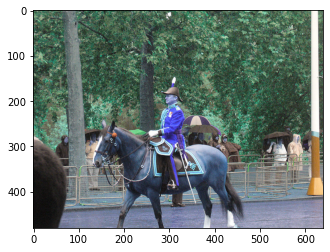

In [3]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
plt.imshow(im)

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE="cpu" #For CPU
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


In [5]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24])
Boxes(tensor([[126.6035, 244.8977, 459.8291, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2351, 398.8111],
        [  0.8217, 281.0327,  78.6072, 478.4209],
        [ 49.3953, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3743, 562.2792, 389.3803],
        [335.2410, 251.9167, 414.7491, 275.9375],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8767, 283.3257, 529.9403, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]]))


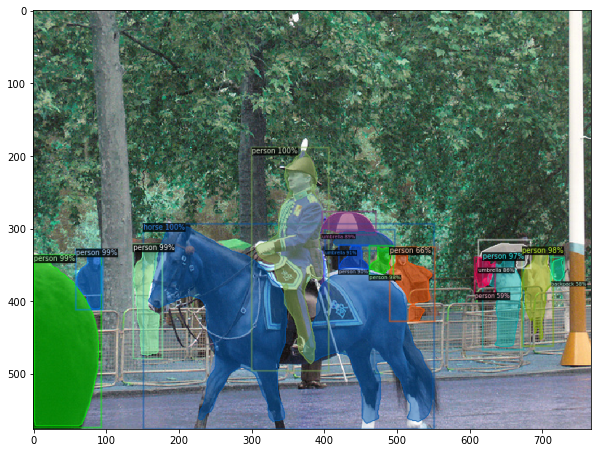

In [6]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(10,10))
plt.imshow(out.get_image()[:, :, ::-1])

In [7]:
# Prepare dataset
# Load dataset info
import pandas as pd

pd.read_csv("df_train_info_detectron2.csv")

,image_id,CategoryId,EncodedPixels,Height,Width
0,b1c3165220a76f6359ab3351cc21bf1c,[0],[],2500,2048
1,7d06c9906257d557aa101e9c73cb10e6,[0],[],2527,2178
2,7bee8aa7c75305b6231950b2a22f4356,[0],[],2475,2484
3,9f9540fc6cacfafb232878e33ce1d8e3,[0],[],3028,2517
4,510bd037beda94d973e885d2c3896d56,[0],[],3408,2680
...,...,...,...,...,...
11995,79c5d4d7f3b2e7a5a183bfbe664c699d,"[7, 8, 5, 7, 5, 7, 8, 8, 7, 14]","[[1644.0, 1333.0, 2052.0, 1701.0], [326.0, 153...",2880,2304
11996,30cdc2c88638bc0f0e61892625a19a94,[0],[],2836,2336
11997,551456e08a1327bdba41297c8ebb8c6f,"[1, 12, 11, 4, 10, 4, 12, 1, 4, 1]","[[1377.0, 869.0, 1784.0, 1347.0], [158.0, 1934...",2760,2676
11998,e03f7ae2393dd3335154562ba6419f74,[0],[],2328,2495


In [8]:
from detectron2.structures import BoxMode
import ast

def get_xray_dicts(df, img_dir):
    
    df.EncodedPixels=df.EncodedPixels.apply(ast.literal_eval)
    df.CategoryId=df.CategoryId.apply(ast.literal_eval)
    dataset_dicts = []
    for idx, v in df.iterrows():
        record = {}
        
        filename = os.path.join(img_dir, v["image_id"]+".jpg")
        #print(filename)
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["EncodedPixels"]
        objs = []
        for idx,anno in enumerate(annos):
            if len(anno)>0:
                poly = [(anno[0], anno[1]),(anno[0], anno[3]),(anno[2], anno[3]),(anno[2], anno[1]),(anno[0], anno[1])]
                poly = [(x + 0.5, y + 0.5) for x, y in poly]
                poly = [p for x in poly for p in x]

                obj = {
                    "bbox": [anno[0], anno[1], anno[2], anno[3]],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": v["CategoryId"][idx]-1, # In the dataframe, 0 means background. For detectron, no need to specify background
                }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


PATH_INPUT = "/home/jupyter/DATA/"
PATH_TRAIN_IMAGES = PATH_INPUT+"train/"
PATH_TRAIN_IMAGES_RESIZED=PATH_INPUT+"no_resized/"

labels_info=pd.read_csv("labels_info.csv")

for d in ["train", "val"]:
    DatasetCatalog.register("xray_" + d, lambda d=d: get_xray_dicts(pd.read_csv(f"df_{d}_info_detectron2.csv"),PATH_TRAIN_IMAGES_RESIZED))
    MetadataCatalog.get("xray_" + d).set(thing_classes=labels_info.class_name.to_list())
balloon_metadata = MetadataCatalog.get("xray_train")

In [14]:
pd.read_csv(f"df_train_info_detectron2.csv").iloc[11997].EncodedPixels

'[[1377.0, 869.0, 1784.0, 1347.0], [158.0, 1934.0, 255.0, 2195.0], [158.0, 1934.0, 255.0, 2195.0], [919.0, 1827.0, 2116.0, 2098.0], [320.0, 1824.0, 741.0, 2032.0], [919.0, 1750.0, 2106.0, 2101.0], [2240.0, 1789.0, 2332.0, 2058.0], [1353.0, 848.0, 1773.0, 1437.0], [912.0, 1847.0, 2114.0, 2178.0], [1433.0, 857.0, 1787.0, 1275.0]]'

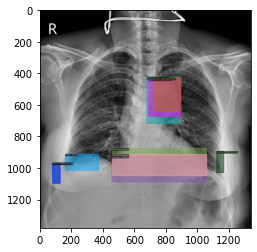

In [17]:
dataset_dicts = get_xray_dicts(pd.read_csv(f"df_train_info_detectron2.csv").iloc[11995:],PATH_TRAIN_IMAGES_RESIZED)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
# training
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("xray_train",)
cfg.DATASETS.TEST = ("xray_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Inference
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])